In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

In [2]:
# load model EfficientNetB0 z ImageNet from ImageNet without top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

# Model without final classification layers - we will use it only for feature extraction
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)


# prediction model 
prediction_model = EfficientNetB0(weights='imagenet')

In [3]:
# Path to the folder with dog images
images_folder = "images/test_cpy"
image_size = (224, 224)  # Size for EfficientNetB0
features = []
labels = []
predictions = []

# Function to preprocess and load images
def preprocess_image(img_path):
    img = load_img(img_path, target_size=image_size)  # Load image and resize it
    img_array = img_to_array(img)                     # Convert image to NumPy array
    img_array = preprocess_input(img_array)           # Scale pixel values for EfficientNet
    return np.expand_dims(img_array, axis=0)          # Add dimension to array (for batch)

# Iterating through images
for filename in os.listdir(images_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(images_folder, filename)
        img_array = preprocess_image(img_path)
        features.append(model.predict(img_array))  # Extract features using EfficientNet
        
        preds = prediction_model.predict(img_array) # Get predictions from the model        
        top_preds = decode_predictions(preds, top=3)[0] # Decode the top 3 predictions
        predictions.append(
            [{"class": label, "score": round(score*100, 2)} for (i, label, score) in top_preds]
        )

        labels.append(filename)                    # Add label (e.g., filename)

# Convert the list of features to a NumPy array
features = np.array(features).squeeze()  # Dimensions: (number_of_images, number_of_features)
print(features.shape)

1/1 [==============================] - 0s 65ms/step
(40, 1280)


In [4]:
# Scaling features to mean 0 and variance 1 (standard deviation of 1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
# Principal Component Analysis (PCA) works best when data is standardized. 
# PCA maximizes variance along the principal components, so features with larger scales might dominate unless the data is scaled.

# fit(): Calculates the mean and standard deviation of each feature from the data.
# transform(): Applies the standardization formula using the calculated mean and standard deviation.
# fit_transform(): Combines both steps.


In [5]:
from sklearn.decomposition import PCA

# Reduce size to 3D(dimentions) (PCA)
pca = PCA(n_components=3)
features_3d = pca.fit_transform(features_scaled)

# IN PCA:
# The eigenvectors of the covariance matrix represent the directions of the principal components.
# The eigenvalues indicate the variance explained by each eigenvector (principal component).
# Eigenvectors are sorted by their corresponding eigenvalues in descending order. The first principal component has the largest eigenvalue.


# tsne = TSNE(n_components=3)
# features_3d = tsne.fit_transform(features)

In [6]:
import json


data_points = []
for i in range(len(features_3d)):
    point = {
        "x": float(features_3d[i, 0]),
        "y": float(features_3d[i, 1]),
        "z": float(features_3d[i, 2]),
        "name": labels[i].rstrip(".jpg").rstrip(".png"),
        "file": labels[i],
        "prediction": predictions[i]
    }
    data_points.append(point)

# Write data to JSON file
output_file = "3d_features_with_labels.json"
with open(output_file, "w") as json_file:
    json.dump(data_points, json_file, indent=4) 

print(f"3D features with labels have been saved to {output_file}")

3D features with labels have been saved to 3d_features_with_labels.json


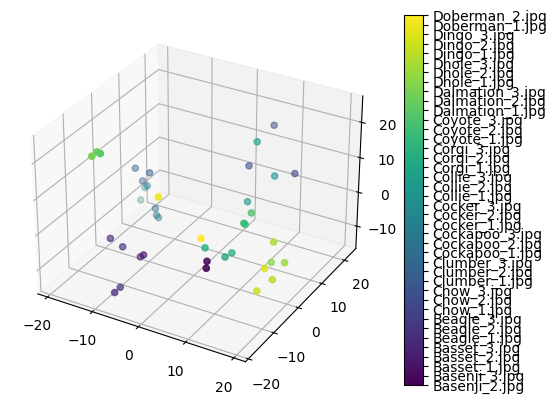

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder


# Convert labels (filenames) to numeric labels
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)
# 3D Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Use numeric_labels for coloring the points
scatter = ax.scatter(features_3d[:, 0], features_3d[:, 1], features_3d[:, 2], c=numeric_labels, cmap='viridis')

# Optional: Add a color bar to indicate the mapping of colors to classes
cbar = plt.colorbar(scatter)
cbar.set_ticks(range(len(label_encoder.classes_)))
cbar.set_ticklabels(label_encoder.classes_)  # Set tick labels to the original class names

plt.show()
